In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

## Oppgave 1


#### 1 a)

For å representere en polymer av en gitt lengde numerisk er det mulig å lagre hele gitteret, inkludert alle null-elementene, som en matrise, hvor sidelengdene er større enn polymeret. Dette er derimot ikke hensiktsmessig ettersom majoriteten av informasjonen lagret er overflødig. For å forenkle dette kan istedet kun selve posisjonen av hver monomer lagres. Polymeren representeres i et 2D kartesisk kordinatsystem, og dermed kan hver monomer posisjon beskrives av en tuppel med kordinatene x og y. Slik kan hele polymeren være representert av en N x 2 matrise.   

#### 1 b)

In [2]:
def polymer(N: int) -> list[int]:
    """
    Function that returns a list of integers representing the polymer with each element being a touple with the x and y coordinates of the monomer
    :param N: int
    :return: list[int]
    """
    return np.array([(0, i) for i in range(-N//2, N//2)])

#### 1 c)

Energien til en gitt polymer er avhengig av antall monomerer som vekselsvirker med hverandre. Reglene for denne vekselvirkningen er oppgitt i seksjon 2 av prosjektheftet. I algoritme 1 og 2, som begge er Monte Carlo-metoder, velges tilfeldig en monomer som roteres om. Ettersom rotasjon i endemonomerene ikke endrer formen av polymeret, men heller kun roterer hele polymeret, vil det heller ikke oppstå noen endring av energien i polymeret. Dermed er det ikke hensiktsmessig å inkludere endemonomerene i utvalget den tilfeldige monomeren trekkes fra. 

#### 1 d)

In [3]:
# Method to display the polymer
def display_polymer(polymer_list: list[int]) -> None:
    """
    Function that displays the polymer in a grid
    :param polymer_list: list[int]
    :return: None
    """
    # Adjust grid boundaries to include all monomers
    grid_size = 2 * len(polymer_list) + 1
    offset = len(polymer_list)
    x = np.linspace(-offset, offset, grid_size)
    X, Y = np.meshgrid(x, x)
    
    Z = np.zeros(X.shape)

    # Calculate intensity values for each monomer (stronger towards the end)
    for i, (x, y) in enumerate(polymer_list):
        intensity = i / (len(polymer_list) - 1) + 0.05
        Z[x + offset, y + offset] = intensity

    # Define a purple colormap
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "purple"])

    plt.pcolormesh(X, Y, Z, cmap=cmap)
    plt.show()

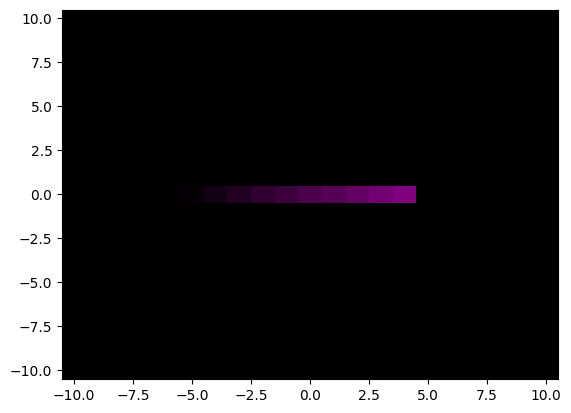

In [4]:
# Test the new Polymer function and display function
polymer_list = polymer(10)

display_polymer(polymer_list)


#### 1 e)

We added our own criteria, we make it a requirement that no monomer can share coordinates with another, thus it cannot be on top of itself

In [5]:
def is_intact_polymer(polymer_object: np.ndarray, N: int) -> bool:
    """
    Check if the polymer is intact using NumPy array operations.
    :param polymer_object: NumPy array of shape (N, 2), representing N monomers.
    :param N: Expected length of the polymer.
    :return: True if the polymer is intact and not on top of itself, False otherwise.
    """
    if polymer_object.shape[0] != N or len(np.unique(polymer_object, axis=0)) != N:
        return False
    diffs = np.diff(polymer_object, axis=0)
    valid_neighbors = ((np.abs(diffs[:, 0]) == 1) & (diffs[:, 1] == 0)) | ((diffs[:, 0] == 0) & (np.abs(diffs[:, 1]) == 1))
    return np.all(valid_neighbors) and not np.any(np.diff(polymer_object, axis=0) == 0)


#### 1f)

In [6]:
def rotate_polymer(polymer_object, xy_val, counter_clockwise):
    """
    Function that rotates the smaller half of the polymer around a point with 90 degrees
    :param polymer_object: NumPy array of shape (N, 2), representing N monomers.
    :param xy_val: tuple[int, int]
    :param counter_clockwise: bool
    :return: NumPy array representing the rotated polymer.
    """
    rotated_polymer = []
    # Convert xy_val to a NumPy array for comparison
    xy_val_array = np.array(xy_val)
    
    # Find all indices where xy_val matches a row in polymer_object
    rotation_indices = np.where((polymer_object == xy_val_array).all(axis=1))[0]
    if rotation_indices.size == 0:
        return polymer_object  # xy_val not found in polymer_object
    rotation_index = rotation_indices[0]  # Use the first occurrence

    # Determine which half to rotate (smaller half or front half if in the middle)
    if rotation_index <= len(polymer_object) // 2:
        # Rotate the front half
        polymer_to_rotate = polymer_object[:rotation_index + 1]
        polymer_remaining = polymer_object[rotation_index + 1:]
    else:
        # Rotate the back half
        polymer_to_rotate = polymer_object[rotation_index:]
        polymer_remaining = polymer_object[:rotation_index]

    # Apply rotation to the chosen half
    for i in range(len(polymer_to_rotate)):
        x, y = polymer_to_rotate[i]
        dx, dy = x - xy_val[0], y - xy_val[1]
        if counter_clockwise:
            new_x, new_y = xy_val[0] - dy, xy_val[1] + dx
        else:
            new_x, new_y = xy_val[0] + dy, xy_val[1] - dx
        rotated_polymer.append((new_x, new_y))

    # Combine the rotated half with the unrotated half
    if rotation_index <= len(polymer_object) // 2:
        result = np.vstack((rotated_polymer, polymer_remaining))
    else:
        result = np.vstack((polymer_remaining, rotated_polymer))

    return result

In [7]:
def rotate_polymer_np(polymer: np.ndarray, center: tuple[int, int], counter_clockwise: bool = True) -> np.ndarray:
    """
    Optimized function to rotate the smaller half of the polymer 90 degrees around a center point using NumPy.
    :param polymer: NumPy array of shape (N, 2), representing N monomers.
    :param center: Center point for rotation, as a tuple of (x, y).
    :param counter_clockwise: True for counter-clockwise rotation, False for clockwise.
    :return: NumPy array representing the rotated polymer.
    """
    # Calculate distances from the center to find the closest monomer as pivot
    pivot_index = np.argmin(np.sum((polymer - np.array(center))**2, axis=1))
    
    # Determine rotation matrix
    rotation_matrix = np.array([[0, 1], [-1, 0]]) if not counter_clockwise else np.array([[0, -1], [1, 0]])
    
    # Determine which half to rotate based on pivot position
    if pivot_index < len(polymer) / 2:
        # Rotate the first half
        to_rotate = polymer[:pivot_index+1] - center
        polymer[:pivot_index+1] = to_rotate @ rotation_matrix + center
    else:
        # Rotate the second half
        to_rotate = polymer[pivot_index:] - center
        polymer[pivot_index:] = to_rotate @ rotation_matrix + center
    
    return polymer

#### 1g)

In [8]:
def algorithm1(N: int, Ns: int) -> (list[int], int):
    counter = 0
    polymer_object = polymer(N)

    for _ in range(Ns):
        # Choose a random monomer
        random_monomer_index = np.random.randint(0, N)
        random_monomer = polymer_object[random_monomer_index]

        # Randomly choose rotation direction
        rotate_clockwise = np.random.choice([True, False])

        # Rotate the polymer
        rotated_polymer = rotate_polymer(polymer_object, random_monomer, not rotate_clockwise)

        # Check if the rotated polymer is intact
        if is_intact_polymer(rotated_polymer, N):
            counter += 1
            polymer_object = rotated_polymer

    return polymer_object, counter


In [9]:
def algorithm1_optimized(N, Ns):
    counter = 0
    polymer = np.array([(0, i) for i in range(-N//2, N//2 + N%2)])
    for _ in range(Ns):
        random_index = np.random.randint(0, N)
        random_monomer = polymer[random_index]
        counter_clockwise = np.random.choice([True, False])
        rotated_polymer = rotate_polymer_np(polymer, random_monomer, counter_clockwise)
        if is_intact_polymer(rotated_polymer, N):
            counter += 1
            polymer = rotated_polymer
    return polymer, counter

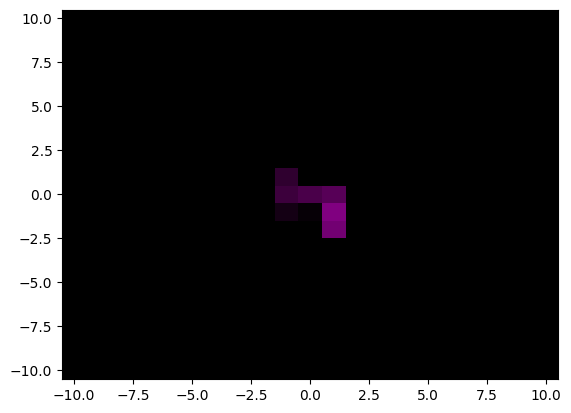

0


In [10]:
tester_, count = algorithm1_optimized(10, 15)
display_polymer(tester_)
print(count)

#### 1h)

In [11]:
# implementasjon med numpy array

def polymer_array(N: int) -> list[int]:
   """
    Function that returns a list of integers representing the polymer with each element being a touple with the x and y coordinates of the monomer
    :param N: int
    :return: list[int]
    """
   return [(0, i) for i in range(-N//2, N//2)]

def is_intact_polymer_array(polymer_object: list[int], N: int) -> bool:
    """
    Function that checks if the polymer is intact
    :param polymer_object: list[int]
    :param N: int
    :return: bool
    """

    # Check if the polymer is the right length
    if len(polymer_object) != N:
        return False

    # Go through each monomer and check if it has a neighbor
    for i in range(N):
        # Hvis det ikke er den første monomeren, sjekk forrige nabo
        if i > 0 and not (abs(polymer_object[i][0] - polymer_object[i-1][0]) == 1 and polymer_object[i][1] == polymer_object[i-1][1]) and not (polymer_object[i][0] == polymer_object[i-1][0] and abs(polymer_object[i][1] - polymer_object[i-1][1]) == 1):
            return False
        
        # If it is not the last monomer, check next neighbor
        if i < N - 1 and not (abs(polymer_object[i][0] - polymer_object[i+1][0]) == 1 and polymer_object[i][1] == polymer_object[i+1][1]) and not (polymer_object[i][0] == polymer_object[i+1][0] and abs(polymer_object[i][1] - polymer_object[i+1][1]) == 1):
            return False
        
        # Check if the monomer is on top of another monomer\n",
        if polymer_object.count(polymer_object[i]) > 1:
            return False
    return True

def rotate_polymer_array(polymer_object: list[int], xy_val: tuple[int, int], counter_clockwise: bool) -> list[int]:
    """
    Function that rotates the smaller half of the polymer around a point with 90 degrees
    :param polymer_object: list[int]
    :param xy_val: tuple[int, int]
    :param counter_clockwise: bool
    :return: list[int]
    """
    rotated_polymer = []
    rotation_index = polymer_object.index(xy_val)

    # Determine which half to rotate (smaller half or front half if in the middle)
    if rotation_index <= len(polymer_object) // 2:
        # Rotate the front half
        polymer_to_rotate = polymer_object[:rotation_index + 1]
        polymer_remaining = polymer_object[rotation_index + 1:]
    else:
        # Rotate the back half
        polymer_to_rotate = polymer_object[rotation_index:]
        polymer_remaining = polymer_object[:rotation_index]

    # Apply rotation to the chosen half
    for x, y in polymer_to_rotate:
        dx, dy = x - xy_val[0], y - xy_val[1]
        if counter_clockwise:
            new_x, new_y = xy_val[0] - dy, xy_val[1] + dx
        else:
            new_x, new_y = xy_val[0] + dy, xy_val[1] - dx
        rotated_polymer.append((new_x, new_y))

    # Combine the rotated half with the unrotated half
    if rotation_index <= len(polymer_object) // 2:
        rotated_polymer.extend(polymer_remaining)
    else:
        rotated_polymer = polymer_remaining + rotated_polymer

    return rotated_polymer

def algorithm1_array(N: int, Ns: int) -> (list[int], int):
    counter = 0
    polymer_object = polymer_array(N)

    for _ in range(Ns):
        # Choose a random monomer
        random_monomer_index = np.random.randint(0, N)
        random_monomer = polymer_object[random_monomer_index]

        # Randomly choose rotation direction
        rotate_clockwise = np.random.choice([True, False])

        # Rotate the polymer
        rotated_polymer = rotate_polymer_array(polymer_object, random_monomer, not rotate_clockwise)

        # Check if the rotated polymer is intact
        if is_intact_polymer_array(rotated_polymer, N):
            counter += 1
            polymer_object = rotated_polymer

    return polymer_object, counter

In [15]:
# check for optimization

# time the algorithm using timeit

%timeit algorithm1_array(150, 10000)
%timeit algorithm1_optimized(150, 10000)



1.93 s ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
627 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Her ser vi at å bruke Numpy arrays og optimalisere rundt linæralgebra for rotasjon gir en betydelig ytelseøkning ovenfor Python array.

## Oppgave 2